In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import os

In [3]:
# Define Custom Dataset
class BloodCellDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = torch.tensor(self.data.iloc[idx, 1:].values.astype(float), dtype=torch.float32)  # WBC & Platelet counts
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [4]:
# Define Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
# Load Data
train_dataset = BloodCellDataset("/kaggle/input/dengue-1/dengue_dataset_multiclass/train/_classes.csv", "/kaggle/input/dengue-1/dengue_dataset_multiclass/train/images", transform)
valid_dataset = BloodCellDataset("/kaggle/input/dengue-1/dengue_dataset_multiclass/valid/_classes.csv", "/kaggle/input/dengue-1/dengue_dataset_multiclass/valid/images", transform)
test_dataset = BloodCellDataset("/kaggle/input/dengue-1/dengue_dataset_multiclass/test/_classes.csv", "/kaggle/input/dengue-1/dengue_dataset_multiclass/test/images", transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [6]:
# Load Pretrained ResNet-152
model = models.resnet152(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # Output 2 values (WBC & Platelet count)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 232MB/s] 


In [7]:
# Define Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
# Training Loop
def train_model(model, train_loader, valid_loader, criterion, optimizer, epochs=10):
    global train_losses, valid_losses
    train_losses = []
    valid_losses = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        # Validation
        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()
        
        train_loss_avg = running_loss / len(train_loader)
        valid_loss_avg = valid_loss / len(valid_loader)
        train_losses.append(train_loss_avg)
        valid_losses.append(valid_loss_avg)
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss_avg:.4f}, Valid Loss: {valid_loss_avg:.4f}")


In [13]:
# Train the Model
train_model(model, train_loader, valid_loader, criterion, optimizer, epochs=20)

# Save the Model
torch.save(model.state_dict(), "resnet152_wbc_platelets.pth")

Epoch 1/20, Train Loss: 1.1566, Valid Loss: 26.5836
Epoch 2/20, Train Loss: 0.8087, Valid Loss: 24.5281
Epoch 3/20, Train Loss: 0.6384, Valid Loss: 24.0483
Epoch 4/20, Train Loss: 0.5893, Valid Loss: 23.4054
Epoch 5/20, Train Loss: 0.5258, Valid Loss: 22.8981
Epoch 6/20, Train Loss: 1.6617, Valid Loss: 22.8093
Epoch 7/20, Train Loss: 0.9730, Valid Loss: 22.7355
Epoch 8/20, Train Loss: 0.9024, Valid Loss: 24.8797
Epoch 9/20, Train Loss: 1.1316, Valid Loss: 26.9420
Epoch 10/20, Train Loss: 0.5006, Valid Loss: 22.8151
Epoch 11/20, Train Loss: 0.4172, Valid Loss: 22.7308
Epoch 12/20, Train Loss: 0.5200, Valid Loss: 23.0044
Epoch 13/20, Train Loss: 0.5160, Valid Loss: 24.5137
Epoch 14/20, Train Loss: 0.7220, Valid Loss: 24.6612
Epoch 15/20, Train Loss: 0.6683, Valid Loss: 24.9794
Epoch 16/20, Train Loss: 0.4864, Valid Loss: 24.0644
Epoch 17/20, Train Loss: 0.6832, Valid Loss: 24.9589
Epoch 18/20, Train Loss: 0.6797, Valid Loss: 22.1280
Epoch 19/20, Train Loss: 1.0251, Valid Loss: 23.9957
Ep

In [16]:
# Test the Model
def test_model(model, test_loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(labels.cpu().numpy())
    
    # Calculate Accuracy (R-squared Score)
    predictions = torch.tensor(predictions)
    actuals = torch.tensor(actuals)
    accuracy = 1 - torch.sum((predictions - actuals) ** 2) / torch.sum((actuals - actuals.mean()) ** 2)
    accuracy_percentage = accuracy.item() * 100
    print(f"Model Accuracy (R-squared): {accuracy.item():.4f} ({accuracy_percentage:.2f}%)")
    
    return predictions, actuals

preds, acts = test_model(model, test_loader)
print("Testing complete!")


Model Accuracy (R-squared): 0.8652 (86.52%)
Testing complete!


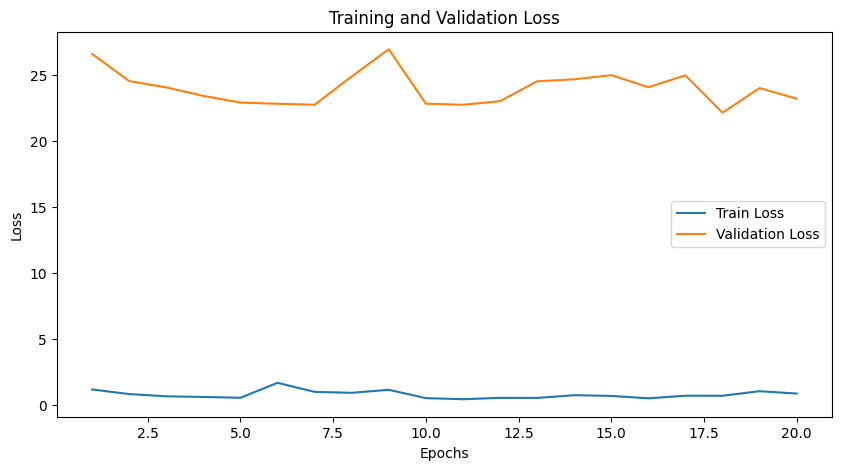

In [15]:
import matplotlib.pyplot as plt

def plot_loss(train_losses, valid_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(valid_losses) + 1), valid_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

# Example usage after training
plot_loss(train_losses, valid_losses)